In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm
import dynesty
from dynesty import plotting as dyplot

### Generate Sample Data for Regression

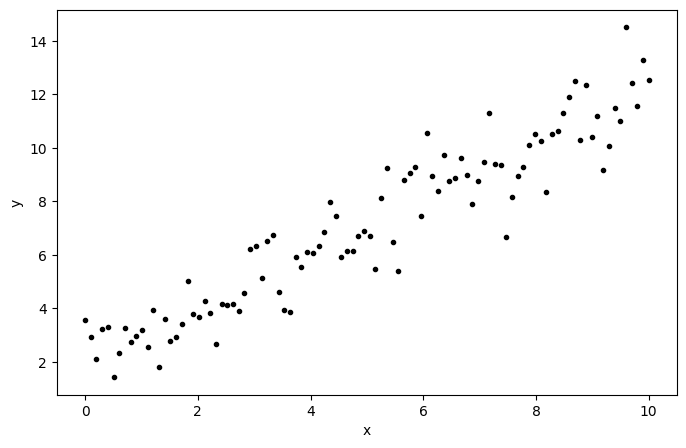

In [4]:
x = np.linspace(0, 10, 100)
y = 1 * x + 2 + np.random.randn(100)    # Add some noise

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(x, y, 'k.', label='Data')
ax.set_xlabel('x')
ax.set_ylabel('y')

plt.show()

### Perform Nested Sampling with Dynesty

I have added two dummy parameters (three and four) to show how they behave between the prior and posterior distributions. Since they are not used in the model, they are not optimised and their distribution stays the same (uninformative).

The main idea when using dynesty is:
1. Define a log_likelihood function
2. Define a prior_transform function to transform the parameter priors from a Uniform(0, 1)
3. Run the Nested Sampler and get the log(Evidence)

As expected, the informative priors (one and two) converge to what we would expect for the true function:
$$
y = m \times x + c,
$$
where $m$ converged to $1$ and $c$ converged to $0$.

12428it [00:08, 1539.15it/s, batch: 2 | bound: 0 | nc: 1 | ncall: 61835 | eff(%): 20.004 | loglstar: -4.383 < -0.175 < -3.705 | logz: -2.521 +/-  0.026 | stop:  0.991]          


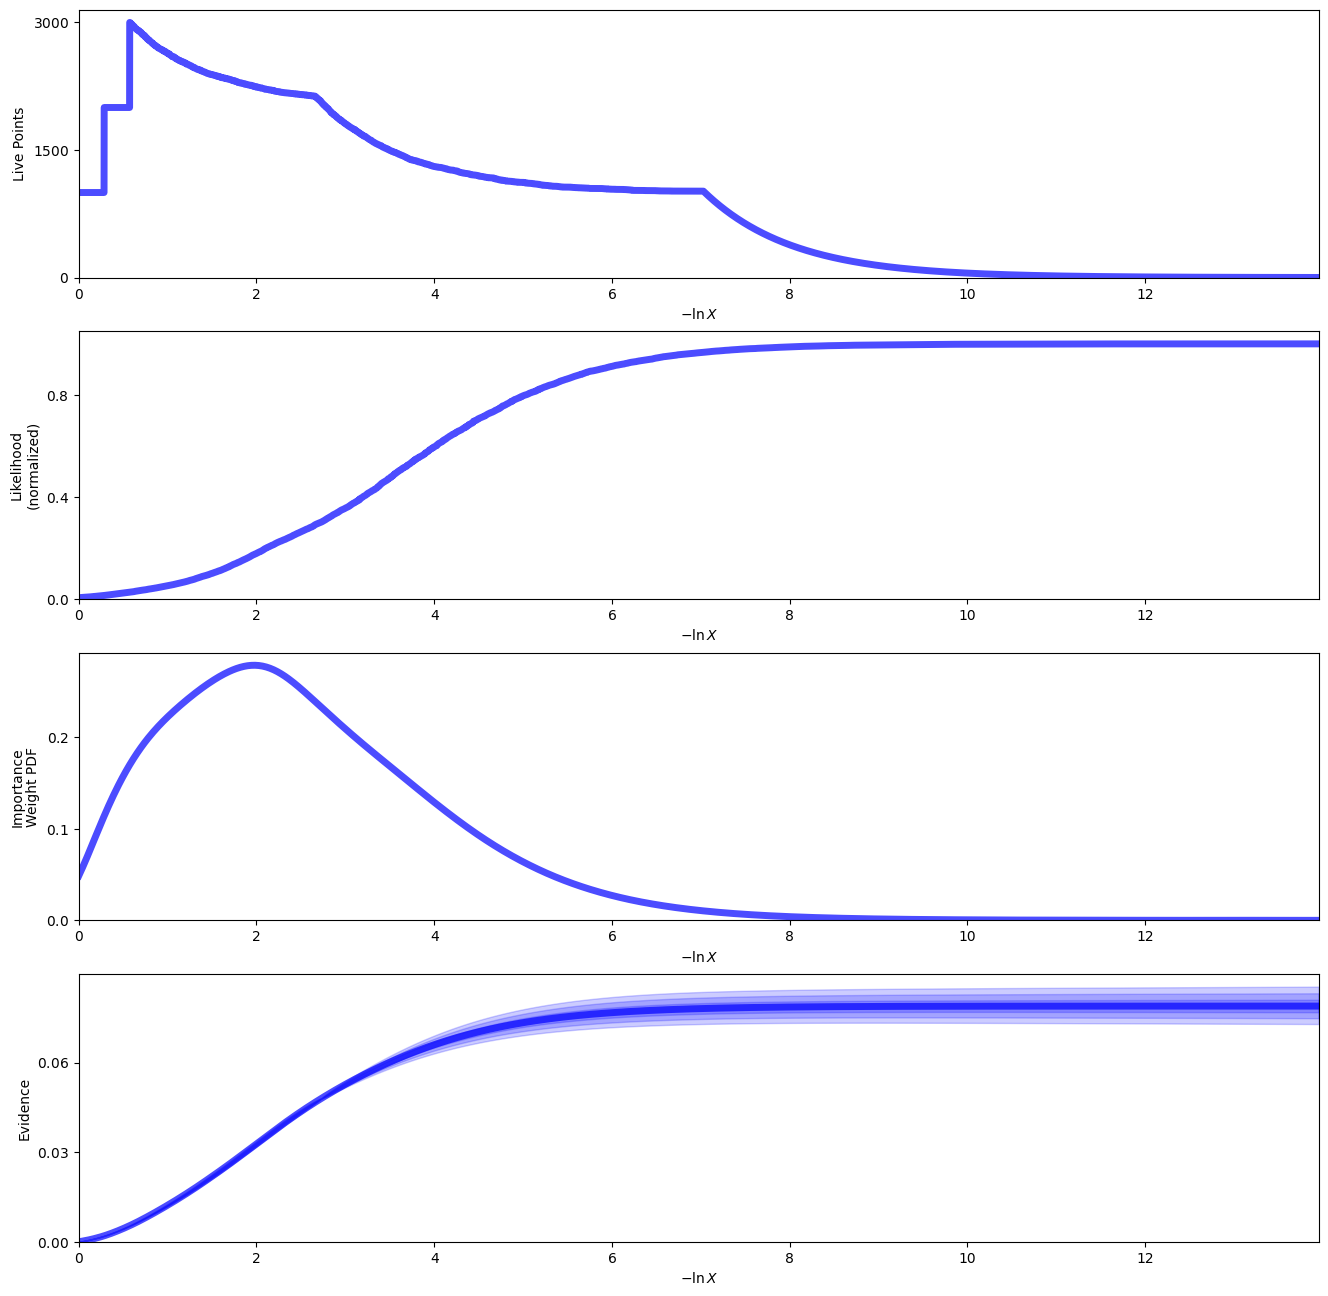

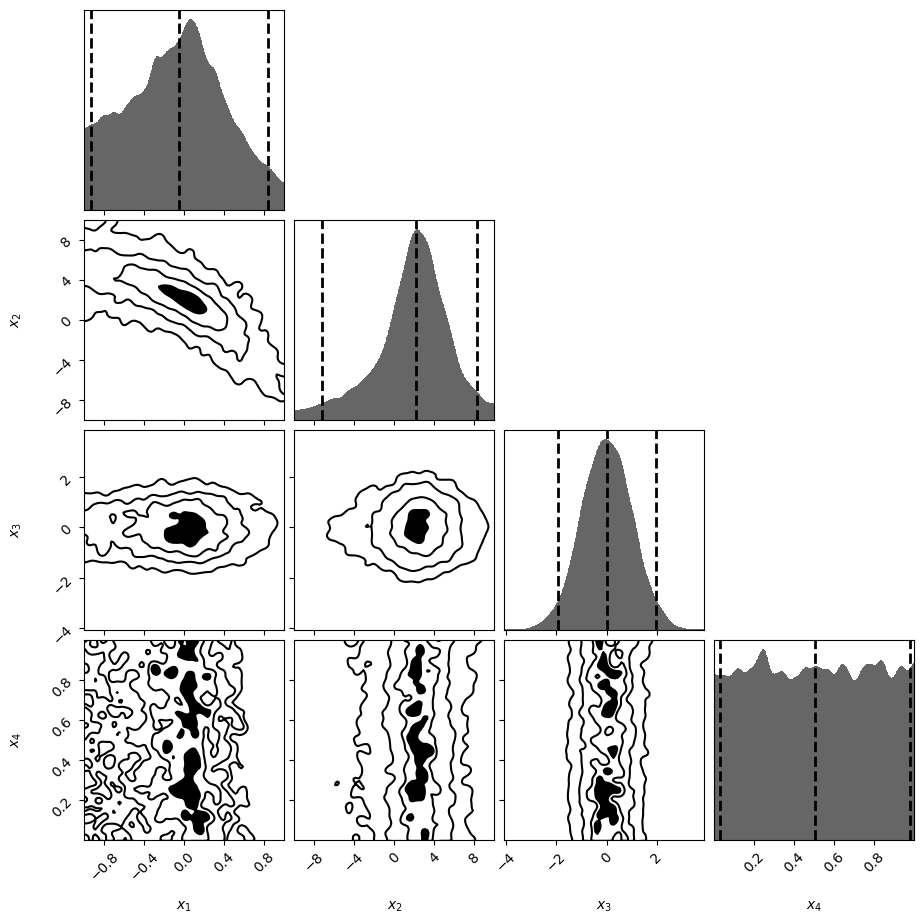

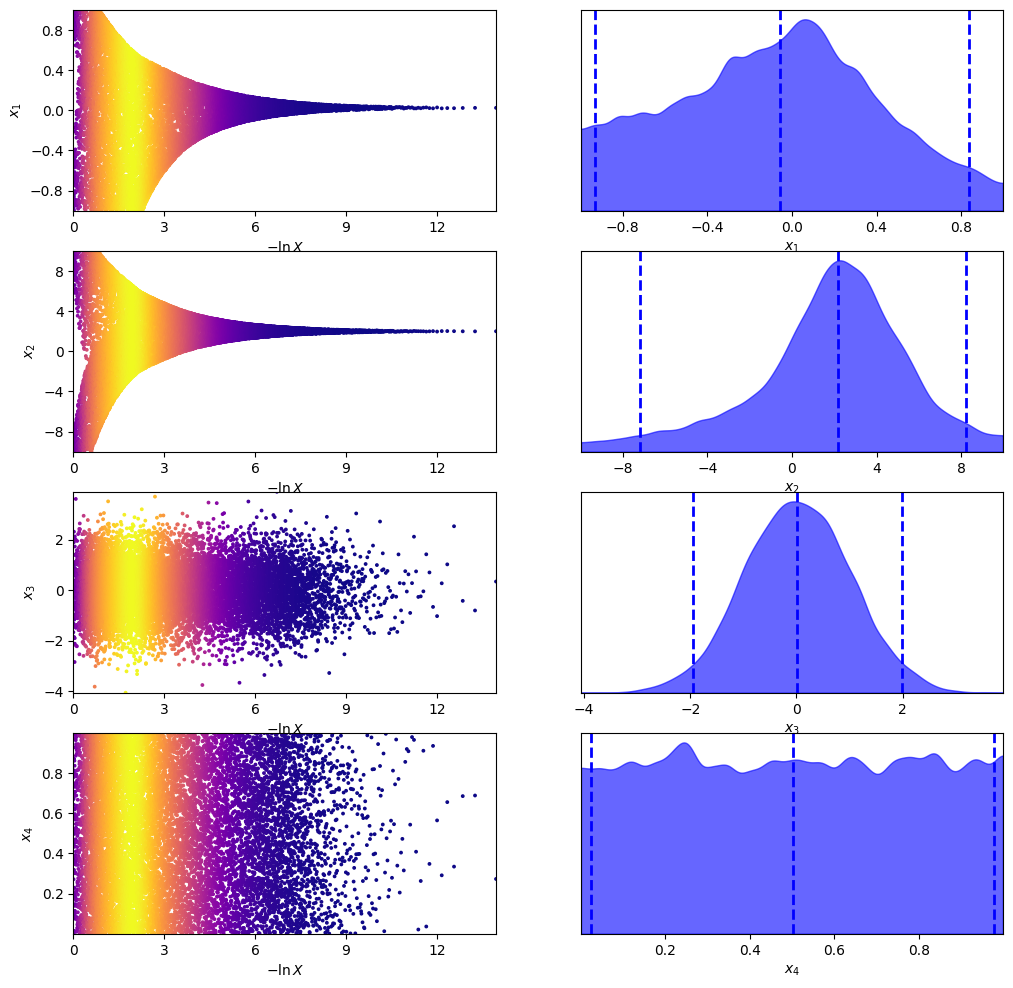

In [5]:
def mean_squared_error_loss(true, pred):
    return np.mean(np.square(true - pred))

def log_likelihood(params):

    param_0 = np.exp(params[0]) # Exponential transformation so that the prior is log-uniform
    param_1 = params[1]

    y_pred = x * param_0 + param_1

    return -np.log(
        mean_squared_error_loss(
            y,                  # True
            y_pred,             # Dummy Prediction
        )
    )

def prior_transform(params):

    transformed = np.array(params)

    transformed[0] = 2 * params[0] - 1                                      # Uniform from -1 to 1
    transformed[1] = 20 * params[1] - 10                                    # Uniform from -10 to 10
    transformed[2] = truncnorm.ppf(params[2], a=-10, b=10, loc=0, scale=1)  # Truncated Normal from -10 to 10

    return transformed

sampler = dynesty.DynamicNestedSampler(log_likelihood, prior_transform, ndim=4, nlive=1000)
sampler.run_nested()

results = sampler.results

fig, axes = dyplot.runplot(results)
fig, axes = dyplot.cornerplot(results)
fig, axes = dyplot.traceplot(results)

In [6]:
posterior_mean = np.mean(results.samples, axis=0)
posterior_median = np.median(results.samples, axis=0)

a_estimated = np.exp(posterior_mean[0])  # Convert log(a) back
b_estimated = posterior_mean[1]          # Intercept stays as is

print(f"Posterior Mean Estimate: a = {a_estimated}, b = {b_estimated}")
print(f"Posterior Median Estimate: a = {np.exp(posterior_median[0])}, b = {posterior_median[1]}")


Posterior Mean Estimate: a = 0.9596874432263237, b = 1.6874359227315057
Posterior Median Estimate: a = 0.9976415430006114, b = 2.0266579622721004
